# Streaming Data Visualisation

<IPython.core.display.Javascript object>


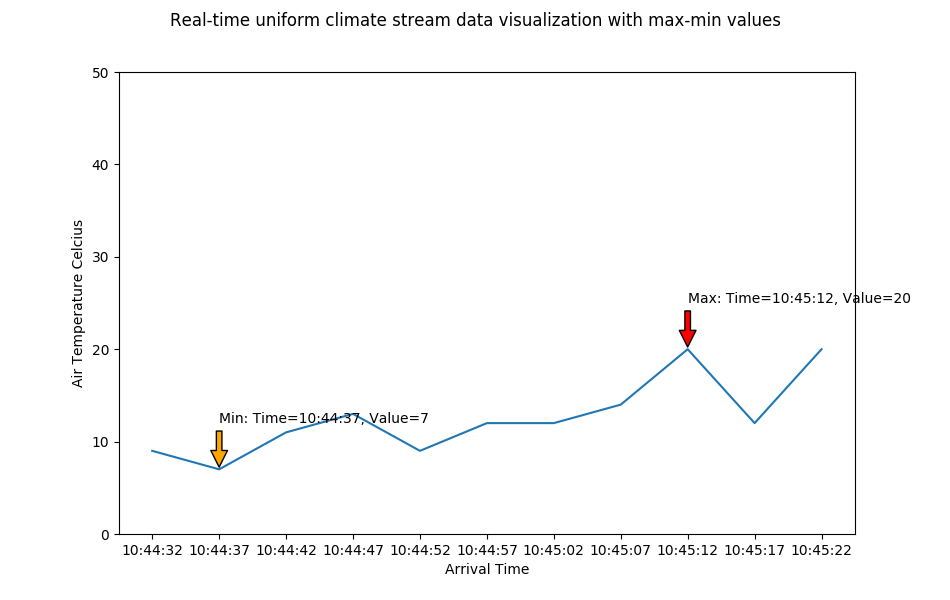

In [6]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'assignment'

def annotate_max(x, y, ax = None): #annotating max values
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None): #annotating min values
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer(): #connecting to consumer
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():#initialising plots
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform climate stream data visualization with max-min values') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature (Celcius)')
        ax.set_ylim(0,50) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:  
            data = json.loads(message.value.decode('utf-8'))
            if data['sender_id'] == "CLIMATE":
                x.append(dt.datetime.now().strftime("%X")) 
                y.append(int(data['data']['air_temperature_celcius']))
                # we start plotting only when we have 10 data points
                if len(y) > 10:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Arrival Time')
                    ax.set_ylabel('Air Temperature Celcius')
                    ax.set_ylim(0,50) 
                    ax.set_yticks([0,10,20,30,40,50])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    

# Static Visualisation for Records with Top 10 Number of Fires

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import sys
import time
import json
import datetime as dt
from pprint import pprint
from pymongo import MongoClient
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from datetime import timedelta

client = MongoClient()
db = client.fit5148_db


fires_time={} #empty dict to store all times and corresponding number of fires
climate = db.climate_hist


initial="00:00:00" #base value for time from which we start aggregating

for i in range(24):
    count = 0
    last = (dt.datetime.strptime(initial,"%H:%M:%S") + timedelta(hours = 1)).time() #incrementing by 1 hour
    #print(last)
    #print(initial)
    number_of_fires = climate.aggregate(
            [{"$unwind" : "$hotspots"},
             {"$match" : {'hotspots.created_time':{ "$gte": str(initial), "$lt": str(last) }}},
             {"$sort": { 'hotspots.created_time': -1 } }])
   
    for record in number_of_fires:    
        count=count+1
        time = str(initial)+" - "+str(last)
        fires_time[time] = count    #count number of fires
    initial=str(last)
        

number_of_exception = climate.aggregate(
            [{"$unwind" : "$hotspots"},
             {"$match" : {'hotspots.created_time':{ "$gte": "23:00:00", "$lte": "23:59:59" }}},
             {"$sort": { 'hotspots.created_time': -1 } }])
c=0
for record in number_of_exception:    #exception case for records between 23:00:00 and 00:00:00
        c=c+1
        time = "23:00:00 - 00:00:00"
        fires_time[time] = c

In [12]:
import operator
sorted_x = sorted(fires_time.items(), key=operator.itemgetter(1),reverse=True) #sorting records in descending order
pprint(sorted_x)

fires = sorted_x[:10] #only picking top 10 records
 

[('04:00:00 - 05:00:00', 1946),
 ('03:00:00 - 04:00:00', 298),
 ('00:00:00 - 01:00:00', 163),
 ('05:00:00 - 06:00:00', 84),
 ('13:00:00 - 14:00:00', 63),
 ('12:00:00 - 13:00:00', 42),
 ('15:00:00 - 16:00:00', 29),
 ('01:00:00 - 02:00:00', 27),
 ('23:00:00 - 00:00:00', 16)]


In [13]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

fire = []
time = []

for i in fires:
    fire.append(i[1]) #storing number of fires data
    time.append(i[0]) #storing time data corresponding to number of fires

print(fire)#checking whether fire values have been recorded
print(time)#checking whether time values have been recorded

y_pos = np.arange(len(fire)) 



[1946, 298, 163, 84, 63, 42, 29, 27, 16]
['04:00:00 - 05:00:00', '03:00:00 - 04:00:00', '00:00:00 - 01:00:00', '05:00:00 - 06:00:00', '13:00:00 - 14:00:00', '12:00:00 - 13:00:00', '15:00:00 - 16:00:00', '01:00:00 - 02:00:00', '23:00:00 - 00:00:00']


<IPython.core.display.Javascript object>


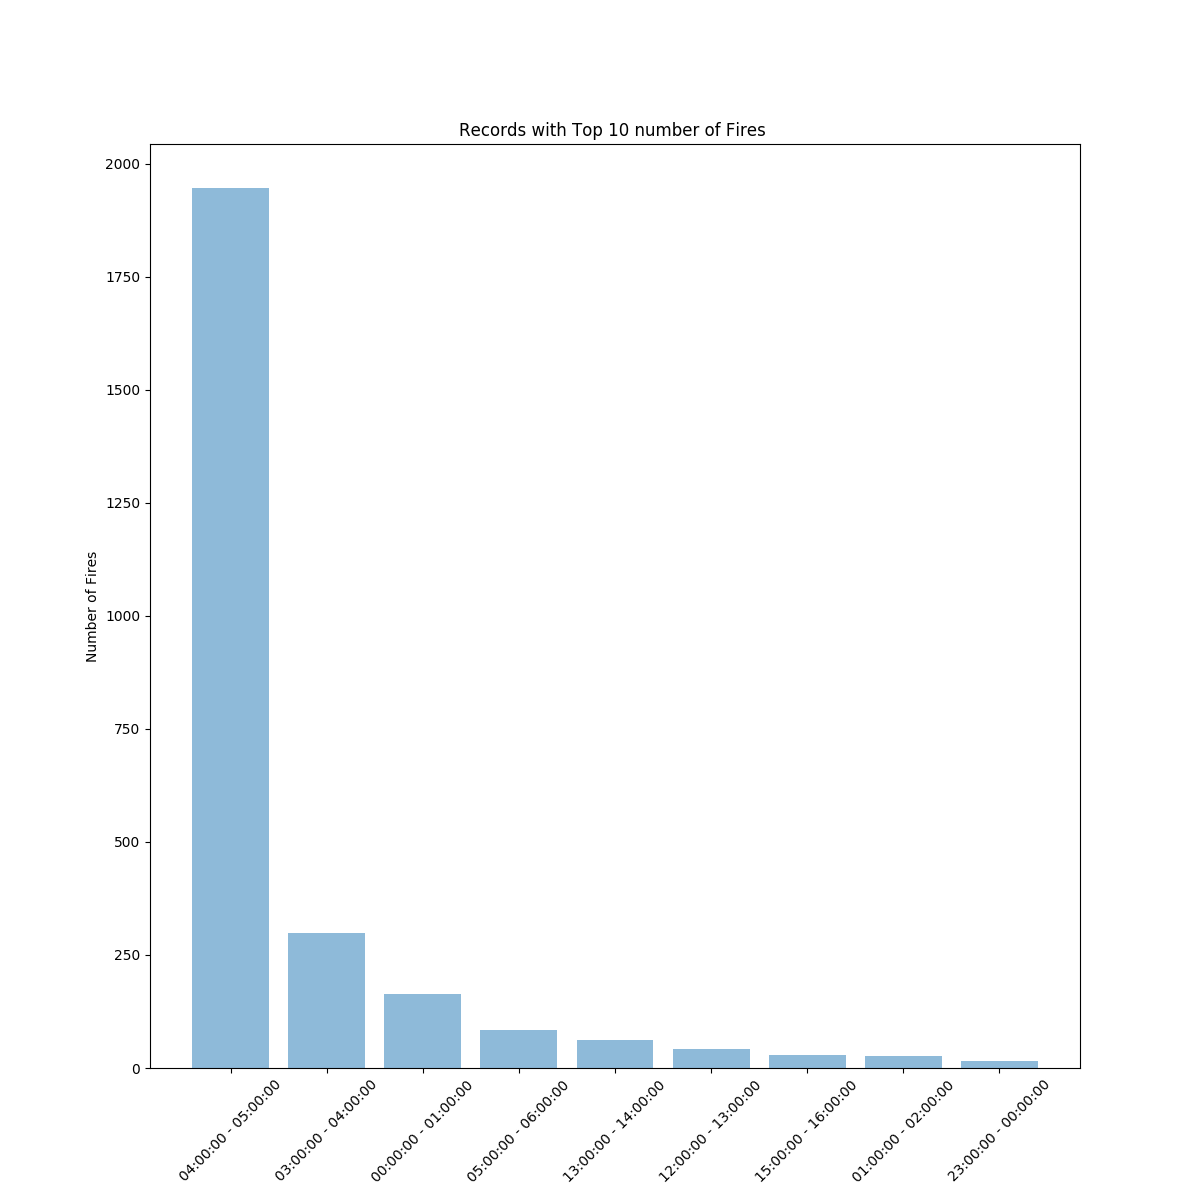

In [14]:
plt.figure(figsize=(12,12))

plt.bar(y_pos,fire, align='center', alpha=0.5)

plt.xticks(y_pos, time)
plt.ylabel('Number of Fires')
plt.title('Records with Top 10 number of Fires ')

plt.xticks(rotation=45)
plt.show()

# Mapping All Fire Records

In [15]:
import gmplot
import pprint
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.020100, 144.964600, 15) # latitude and longitude of victoria


In [16]:
from pymongo import MongoClient
client = MongoClient()
db = client.fit5148_db
climate_streaming = db.climate_hist
# Preparing the data for plotting
results = results = climate_streaming.aggregate(
            [{"$unwind" : "$hotspots"}])

In [17]:
gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"
for row in results: #for every hotspot records
    gmap.marker(float(row['hotspots']['latitude']), float(row['hotspots']['longitude']),title="Confidence:"+str(row['hotspots']["confidence"])+", Air Temperature:"+str(row['air_temperature_celcius'])+", Surface Temperature:"+str(row['hotspots']["surface_temperature_celcius"])+", Relative Humidity:"+str(row['relative_humidity']))

In [18]:
import webbrowser
# Drawing the map
gmap.draw("fires.html")
webbrowser.open_new("fires.html")

True